# Does traditional features improve SotA CNNs?

In [1]:
#import numpy as np 
#import pandas as pd
import PIL
import skimage.feature
import sklearn
import torch
import fastai
import pretrainedmodels

from tqdm import tqdm_notebook
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold

packages = [
  ["Numpy",         np.__version__,        "Numbers"],
  ["Pandas",        pd.__version__,        "Data manipulation"],
  ["Pillow",        PIL.__version__,       "Image"],
  ["Skimage",       skimage.__version__,   "Image"],
  ["Scikit-learn",  sklearn.__version__,   "Machine learning"],
  ["Pytorch",       torch.__version__,     "Low level deep learning"],
  ["Fast.ai",       fastai.__version__,    "High level deep learning"],
  ["Cadene", pretrainedmodels.__version__, "Pretrained deep learning models"]]

new_df = pd.DataFrame(columns=["Package", "Version", "Description"], data=packages)
new_df.style.set_properties(**{'text-align': 'left'})

,Package,Version,Description
0,Numpy,1.15.4,Numbers
1,Pandas,0.24.2,Data manipulation
2,Pillow,5.4.1,Image
3,Skimage,0.14.2,Image
4,Scikit-learn,0.20.1,Machine learning
5,Pytorch,1.0.1,Low level deep learning
6,Fast.ai,1.0.51,High level deep learning
7,Cadene,0.7.4,Pretrained deep learning models


# Data

In [2]:
path     = pathlib.Path("E:/Datasets/TFM/histologyDS2828")
csv_path = path / "imageClasses.txt"
df       = pd.read_csv(csv_path, header=None, delim_whitespace=True, names=['Image', 'Label'])
df       = df.replace({'Label': {1:"Conective", 2:"Ephitelial", 3:"Muscular", 4:"Nervous"}})

###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df.Image.values
y = df.Label.values
train_idxs_fold = []
valid_idxs_fold = []
cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

##################################### Src data

src  = (ImageList.from_df(df, path, folder='imgs')
        .split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0])
        .label_from_df(cols='Label'))

def get_data(bs, size):
    return (src.transform(get_transforms(flip_vert=True, max_warp=None), size=size)
            .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

data = get_data(bs=16, size=224)

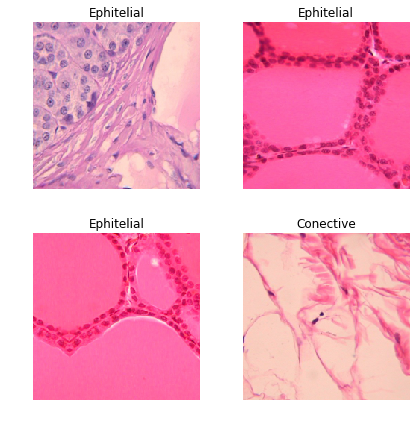

In [3]:
data.show_batch(rows=2, figsize=(6,6))

# Choose a pretrained model
See available pretrained models

In [4]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [5]:
def cadene_model(model_name):
    def mymodel(pretrained=True, **kwargs):
        return pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    return mymodel

model = cadene_model('se_resnext50_32x4d')                # this returns a function
learn = cnn_learner(data, model, metrics=accuracy, cut=-2) # cut parameter is different for each model

# Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


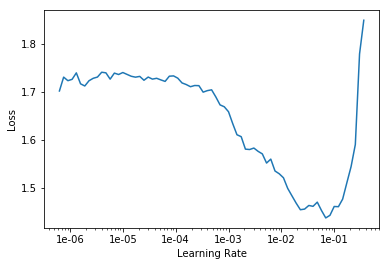

In [34]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.839634,0.631370,0.810526
2,0.607223,0.293917,0.887719
3,0.445466,0.239536,0.919298


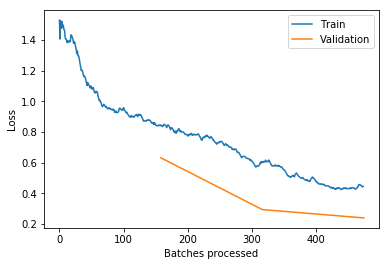

In [37]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


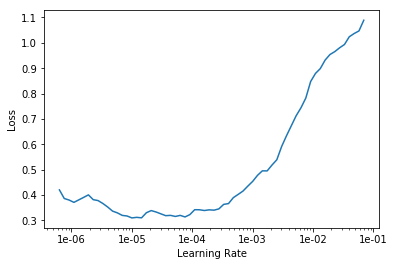

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(4, 1e-5)

epoch,train_loss,valid_loss,accuracy
1,0.375841,0.208565,0.933333
2,0.348767,0.185677,0.947368
3,0.328749,0.185470,0.936842
4,0.352022,0.181701,0.943860


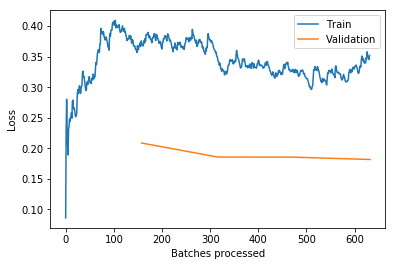

In [40]:
learn.recorder.plot_losses()

In [45]:
learn.save("se_resnext50-3+4-epochs")

# Test

In [6]:
learn.load("se_resnext50-3+4-epochs");

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

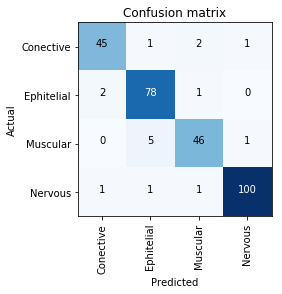

In [42]:
interp.plot_confusion_matrix()

## [Optional] Bigger images
Retrain with bigger images

In [5]:
data  = get_data(10, 480)
model = cadene_model('se_resnext50_32x4d')

learn = create_cnn(data, model, metrics=accuracy, cut=-2) # cut parameter is different for each model
learn.load("se_resnext50-3+4-epochs");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


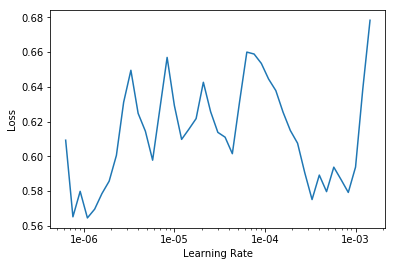

In [6]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.571343,0.207742,0.908772
2,0.406786,0.164769,0.940351
3,0.310920,0.160478,0.933333


# Extract high features (se-resnext)
The last feature vector of the model is a vector of size 512

In [11]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=4, bias=True)
)

In [48]:
################################## Get data
src  = ImageList.from_df(df, path, folder='imgs')
data = (src.split_none()
        .label_from_df(cols='Label')
        .transform(([],[]), size=224)
        .databunch(bs=16, num_workers=0)
        .normalize(imagenet_stats))

################################## Get model

learn.load("se_resnext50-3+4-epochs");
model    = learn.model.eval()
model[1]= model[1][:-1] # Remove last linear!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def high_features(dataset, model):
    
    num_samples = len(dataset)
    h_feats = np.empty([num_samples, 512])
    
    for i in tqdm_notebook(range(num_samples)):
        
        img_tnsr   = dataset[i][0].data.cuda()[None,:]         # [1, 3, 224, 224] cuda tensor
        h_feats[i] = model(img_tnsr)[0].cpu().detach().numpy() # [512] cpu numpy

    return h_feats

h_feats = high_features(data.train_ds, model)
np.save('../Features/hist_seresnext.npy', h_feats)

# Fusion

In [3]:
x_low  = np.load('../Features/hist_low.npy')
x_low  = sklearn.preprocessing.StandardScaler().fit_transform(x_low) # Normalice
x_high = np.load('../Features/hist_seresnext.npy')

x = np.concatenate((x_low, x_high), axis=1)
y = pd.factorize(df['Label'])[0]

x_low.shape, x_high.shape

((2828, 25), (2828, 512))

# Train fusion

In [8]:
learn = 0
all_pred = np.array([])
all_real = np.array([])
    
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):

    ########################################################## GET K-FOLD DATA (numpy)
    x_train, y_train = x[train_index], y[train_index]
    x_valid, y_valid = x[valid_index], y[valid_index]
        
    ########################################################## Get tensor datasets
    train_ds = torch.utils.data.TensorDataset(torch.from_numpy(x_train).to(torch.float32),
                                              torch.from_numpy(y_train).to(torch.int64))
    valid_ds = torch.utils.data.TensorDataset(torch.from_numpy(x_valid).to(torch.float32),
                                              torch.from_numpy(y_valid).to(torch.int64))
    
    ########################################################## Get databunch
    dataFusion = DataBunch.create(train_ds, valid_ds, bs=16, num_workers=0)

    ########################################################## Define net
    H   = 200
    net = nn.Sequential(nn.Linear(x.shape[1], H),
                        nn.BatchNorm1d(H),
                        nn.ReLU(),
                        nn.Linear(H, 4)).cuda()
    
    #net = nn.Sequential(nn.Linear(x.shape[1], 4))
    
    ########################################################## Train
    learn = Learner(dataFusion, net, metrics=accuracy)
    #learn.lr_find()
    #learn.recorder.plot()
    learn.fit_one_cycle(30, 1e-4)
    input("pulse")
    
    ########################################################## Test
    pred, real = learn.get_preds()
    pred = torch.argmax(pred, dim=1)
    pred      = pred.numpy()
    real      = real.numpy()
    all_pred = np.append(all_pred, pred)
    all_real = np.append(all_real, real)
    print("Fold", i+1, "  Accuracy:", sklearn.metrics.accuracy_score(real, pred))

    break
    
print("================================")
print("Accuracy:        ",   sklearn.metrics.accuracy_score(all_real, all_pred))
print("Accuracy (balan):",   sklearn.metrics.balanced_accuracy_score(all_real, all_pred))
print("Confusion matrix:\n", sklearn.metrics.confusion_matrix(all_real, all_pred))

Fold 1   Accuracy: 0.7719298245614035
Accuracy:         0.7719298245614035
Accuracy (balan): 0.7474274112045726
Confusion matrix:
 [[31  6  8  4]
 [ 5 68  1  7]
 [ 3  7 36  6]
 [ 4  9  5 85]]


Fold 1   Accuracy: 0.9122807017543859
Fold 2   Accuracy: 0.8982456140350877
Fold 3   Accuracy: 0.9122807017543859
Fold 4   Accuracy: 0.8842105263157894
Fold 5   Accuracy: 0.9042553191489362
Fold 6   Accuracy: 0.900709219858156
Fold 7   Accuracy: 0.8932384341637011
Fold 8   Accuracy: 0.9039145907473309
Fold 9   Accuracy: 0.9074733096085409
Fold 10   Accuracy: 0.8861209964412812
Accuracy:         0.9002828854314003
Accuracy (balan): 0.8918214644039342
Confusion matrix:
 [[406  27  26  25]
 [ 21 743  15  25]
 [ 22  12 456  24]
 [ 26  37  22 941]]


# Train only high

In [21]:
x = x_high

all_pred = np.array([])
all_real = np.array([])

for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):

    ########################################################## GET K-FOLD DATA (numpy)
    x_train, y_train = x[train_index], y[train_index]
    x_valid, y_valid = x[valid_index], y[valid_index]
        
    ########################################################## TRAIN
    model = MLPClassifier(hidden_layer_sizes=170, max_iter=1000, validation_fraction=0, random_state=0)
    model.fit(x_train, y_train)

    ########################################################## Test
    pred     = model.predict(x_valid)
    real     = y_valid
    all_pred = np.append(all_pred, pred)
    all_real = np.append(all_real, real)
    print("Fold", i+1, "  Accuracy:", sklearn.metrics.accuracy_score(real, pred))
    
print("================================")
print("Accuracy:        ",   sklearn.metrics.accuracy_score(all_real, all_pred))
print("Accuracy (balan):",   sklearn.metrics.balanced_accuracy_score(all_real, all_pred))
print("Confusion matrix:\n", sklearn.metrics.confusion_matrix(all_real, all_pred))

Fold 1   Accuracy: 0.8807017543859649
Fold 2   Accuracy: 0.8631578947368421
Fold 3   Accuracy: 0.856140350877193
Fold 4   Accuracy: 0.8526315789473684
Fold 5   Accuracy: 0.875886524822695
Fold 6   Accuracy: 0.8829787234042553
Fold 7   Accuracy: 0.8220640569395018
Fold 8   Accuracy: 0.8790035587188612
Fold 9   Accuracy: 0.8683274021352313
Fold 10   Accuracy: 0.8505338078291815
Accuracy:         0.8631541725601132
Accuracy (balan): 0.8543496586063758
Confusion matrix:
 [[394  29  28  33]
 [ 26 716  21  41]
 [ 26  20 428  40]
 [ 35  53  35 903]]


# Traditional features

- **Texture features**: 8 matrices * 4 features each = 32 total features
  - First acquire the gray-level co-occurrence matrix G (2 distances, 4 angles = 2*4 = 8 matrices)
  - Then, we employ:
    - **Angular second moment** (ASM)
    - **Entropy** (ENT)
    - **Contrast** (CON)
    - **Correlation** (COR)
- **Color moment features**: For each RGB channel compute 3 features: 3x3 = 9 features:
  - First color moment (**Mean**)
  - Second color moment (**Std**)
  - Third color moment (**Skewness**)
- Other
    - Gabor filter
    - LBP:      local binary pattern
    - LTP:		local ternary pattern
    - HOG:		Histogram of Oriented Gradients
    - PHOG:		Pyramid Histogram of Oriented Gradients
    - ACC:		Auto Color Correlogram
    - BoVW:		Bag-of-Visual-Words
    - CEDD:		Color and Edge Directivity Descriptor
    - CENTRIST:	CENsus TRansform hISTogram
    - EHD:		Edge Histogram Descriptor
    - dense SIFT
    - Opponent color space